In [1]:
### 常规分析包
import os
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, pearsonr, spearmanr
from scipy.spatial import distance
### 绘图包
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # 输出PDF文字可编辑
### 其他
import cloudpickle as pickle
import warnings
warnings.filterwarnings("ignore") # 报错提示
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [2]:
meta = pd.read_csv('../Data_preprocess/1.1.MetaData.tsv', sep='\t', index_col=0)
meta.head(1)
data = pd.read_csv('../Data/16S/MZJ_dada2_table_ASV.tsv', sep='\t', index_col=0, skiprows=1)
data = data/data.sum()*100
data.shape
data.head(1)

taxonomy = pd.read_csv('../Data/16S/MZJ_dada2_taxonomy_GG.tsv', sep='\t', index_col=0)
taxonomy.head(1)

,SampleID,SampleID_1,Child_ID,Sample_type,Day,Time,MotherID,WMS,Gender,Mode of delivery,...,Day of the last sample,Number of samples,Day of introducing solid food,Day of breastfeeding cessation,Solid food,Breastfeeding,"Feeding mode(BFD:0,MFD:1)","Sibling(Y:1,N:0)","PAE(Y:1,N:0)","Allergy(Y:1,N:0)"
ID,,,,,,,,,,,,,,,,,,,,,
C11_10,11_10,D_10,11,C,25.0,T10,M11_M,0,Female,C-section,...,352.0,25.0,176.0,356.0,0.0,1.0,0.0,0.0,0.0,1.0


(10066, 466)

,C11_10,C1_11,C1_12,C1_13,C1_14,C1_15,C1_16,C1_2,C1_21,C1_22,...,M21_M,M25_M,M26_M,M28_M,M29_M,M31_M,M32_M,M34_M,M35_M,M4_M
#OTU ID,,,,,,,,,,,,,,,,,,,,,
3303dcf065483fbf1a02ff00a59b7848,0.0,0.0,0.244346,0.242387,0.161678,0.0,0.90248,7.03667,3.776086,0.551905,...,0.0,0.0,0.0,0.0,0.0,0.0,0.66861,0.0,0.0,0.0


,Taxon,Confidence
Feature ID,,
3303dcf065483fbf1a02ff00a59b7848,k__Bacteria; p__Proteobacteria; c__Gammaproteo...,1.0


In [3]:
tcgsa = pd.read_csv('../Results/2.1.1. TcGSA_ASV_rel(0.1S4P5EC).csv', index_col=0)
tcgsa.head(1)

,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,25,26,27,Cluster
3303dcf065483fbf1a02ff00a59b7848,0.868041,1.127654,1.338262,1.482767,1.500521,1.372479,1.173388,0.980821,0.869184,0.881701,...,2.381668,2.446145,2.533824,2.708566,2.864747,2.879094,2.617276,2.061066,1.327369,1


In [4]:
def diff_analysis_anova(data, groups):
    '''
    # data : data set with sample in index and item in columns
    # groups : 分组信息，numpy array
    # return : statistic table
    '''
    from scipy.stats import f_oneway
    import statsmodels.stats.multitest as multi
    statistics = []
    gs = sorted(set(groups))
    for item in data.columns:
        #stat, p = f_oneway(*[data.loc[groups==g, item] for g in set(groups)])
        try:
            stat, p_value = f_oneway(*[data.loc[groups==g, item] for g in gs])
        except:
            f, p_value = 0, 1.0
        p_value = 1.0 if str(p_value)=='nan' else p_value
        statistics.append([item, gs, [list(groups).count(g) for g in gs], 
                           [data.loc[groups==g, item].mean() for g in gs], p_value])
    statistics = pd.DataFrame(statistics, index = data.columns, columns = ['ID', 'Groups', 'N', 'AveExpr','P.Value'])
    statistics['adj.P.Val'] = multi.multipletests(statistics['P.Value'], method = 'fdr_bh')[1]
    statistics = statistics.sort_values('P.Value')
    return statistics

In [5]:
Child_samples = [i for i in data.columns if i[0]=='C']
stages = []
stages.append([i for i in Child_samples if meta.loc[i, 'Time'] in ['T1', 'T2']])
stages.append([i for i in Child_samples if meta.loc[i, 'Time'] in ['T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 
                                                                   'T10', 'T11']])
stages.append([i for i in Child_samples if meta.loc[i, 'Time'] in ['T12', 'T13', 'T14', 'T15', 'T16', 'T17', 
                                                                   'T18', 'T19', 'T20', 'T21', 'T22', 'T23']])
stages.append([i for i in Child_samples if meta.loc[i, 'Time'] in ['T24', 'T25', 'T26', 'T27']])
Groups = []
for i in Child_samples:
    for j in range(4):
        if i in stages[j]:
            Groups.append('Stage'+str(j+1))
            break
Groups = np.array(Groups)
len(Child_samples), len(Groups)
results = diff_analysis_anova(data.loc[tcgsa.index, Child_samples].T, Groups)

(450, 450)

In [6]:
results['Cluster'] = tcgsa.loc[results.index, 'Cluster']
results['taxonomy'] = taxonomy.loc[results.index, 'Taxon']

In [49]:
results.to_csv('../Results_0609/6.1. 不同时期菌种差异分析.tsv', sep='\t')

In [7]:
results.head(1)
results.shape, results.loc[results['adj.P.Val']<=0.05, :].shape

,ID,Groups,N,AveExpr,P.Value,adj.P.Val,Cluster,taxonomy
4b3957b27c7d487c15621a61688fb28f,4b3957b27c7d487c15621a61688fb28f,"[Stage1, Stage2, Stage3, Stage4]","[16, 160, 202, 72]","[1.3344250107094509, 0.16102573395405365, 0.01...",5.085898e-11,1.576628e-08,2,k__Bacteria; p__Firmicutes; c__Clostridia; o__...


((310, 8), (223, 8))

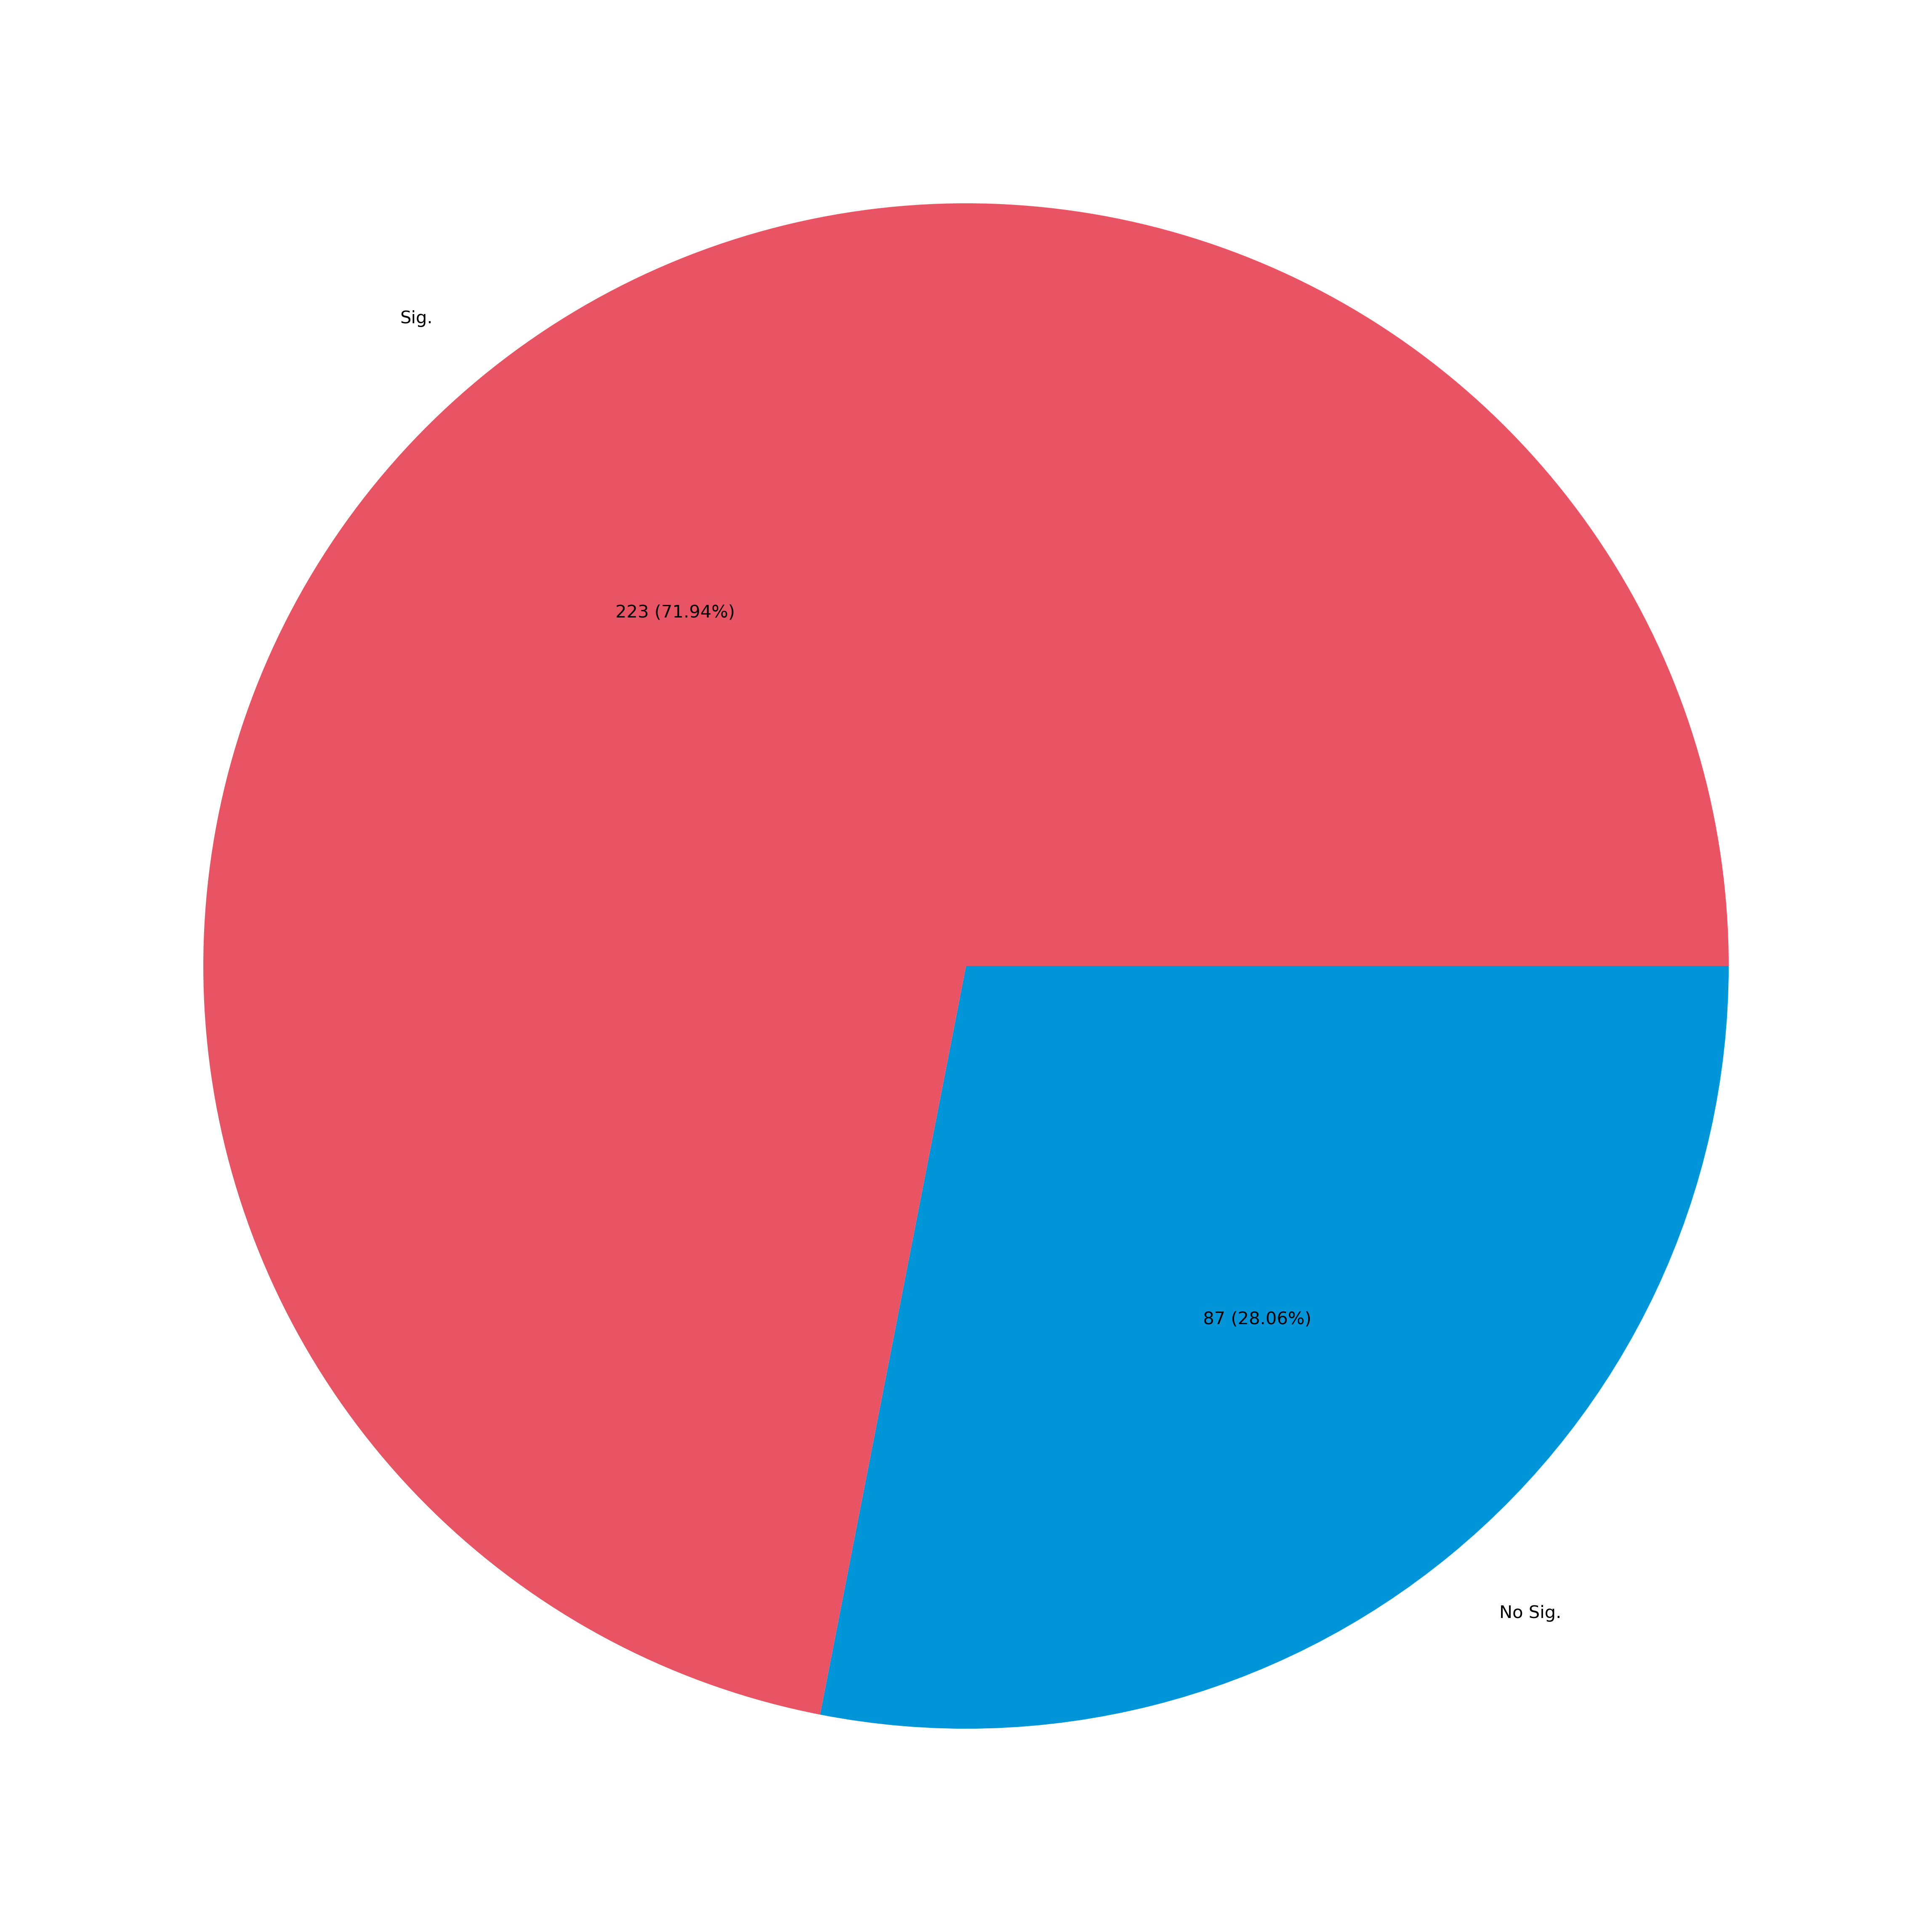

In [82]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d} ({p:.2f}%)'.format(p=pct, v=val)
    return my_autopct

fig = plt.figure(figsize=(20, 20), dpi=300)
_ = plt.pie([223, 310-223], labels=['Sig.', 'No Sig.'], pctdistance=0.6, labeldistance=1.1, 
            colors=['#e95464', '#0095d9'], rotatelabels=False, autopct=make_autopct([223, 310-223]))
fig.savefig('../Results_0609/6.1. 不同时期菌种差异数量统计_pie.pdf', dpi=300)

In [90]:
statistc = pd.DataFrame(np.zeros([5, 5]), index=['Stage1', 'Stage2', 'Stage3', 'Stage4', 'No Sig.'], 
                        columns=['Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 'Cluster5'])
for i in results.index:
    fdr = results.loc[i, 'adj.P.Val']
    if fdr<=0.05:
        stage = 'Stage'+str(np.array(results.loc[i, 'AveExpr']).argmax()+1)
    else:
        stage = 'No Sig.'
    cluster = 'Cluster'+str(results.loc[i, 'Cluster'])
    statistc.loc[stage, cluster] += 1
statistc

,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5
Stage1,0.0,36.0,0.0,0.0,17.0
Stage2,0.0,67.0,11.0,0.0,5.0
Stage3,22.0,0.0,25.0,0.0,0.0
Stage4,39.0,0.0,0.0,0.0,1.0
No Sig.,27.0,19.0,5.0,11.0,25.0


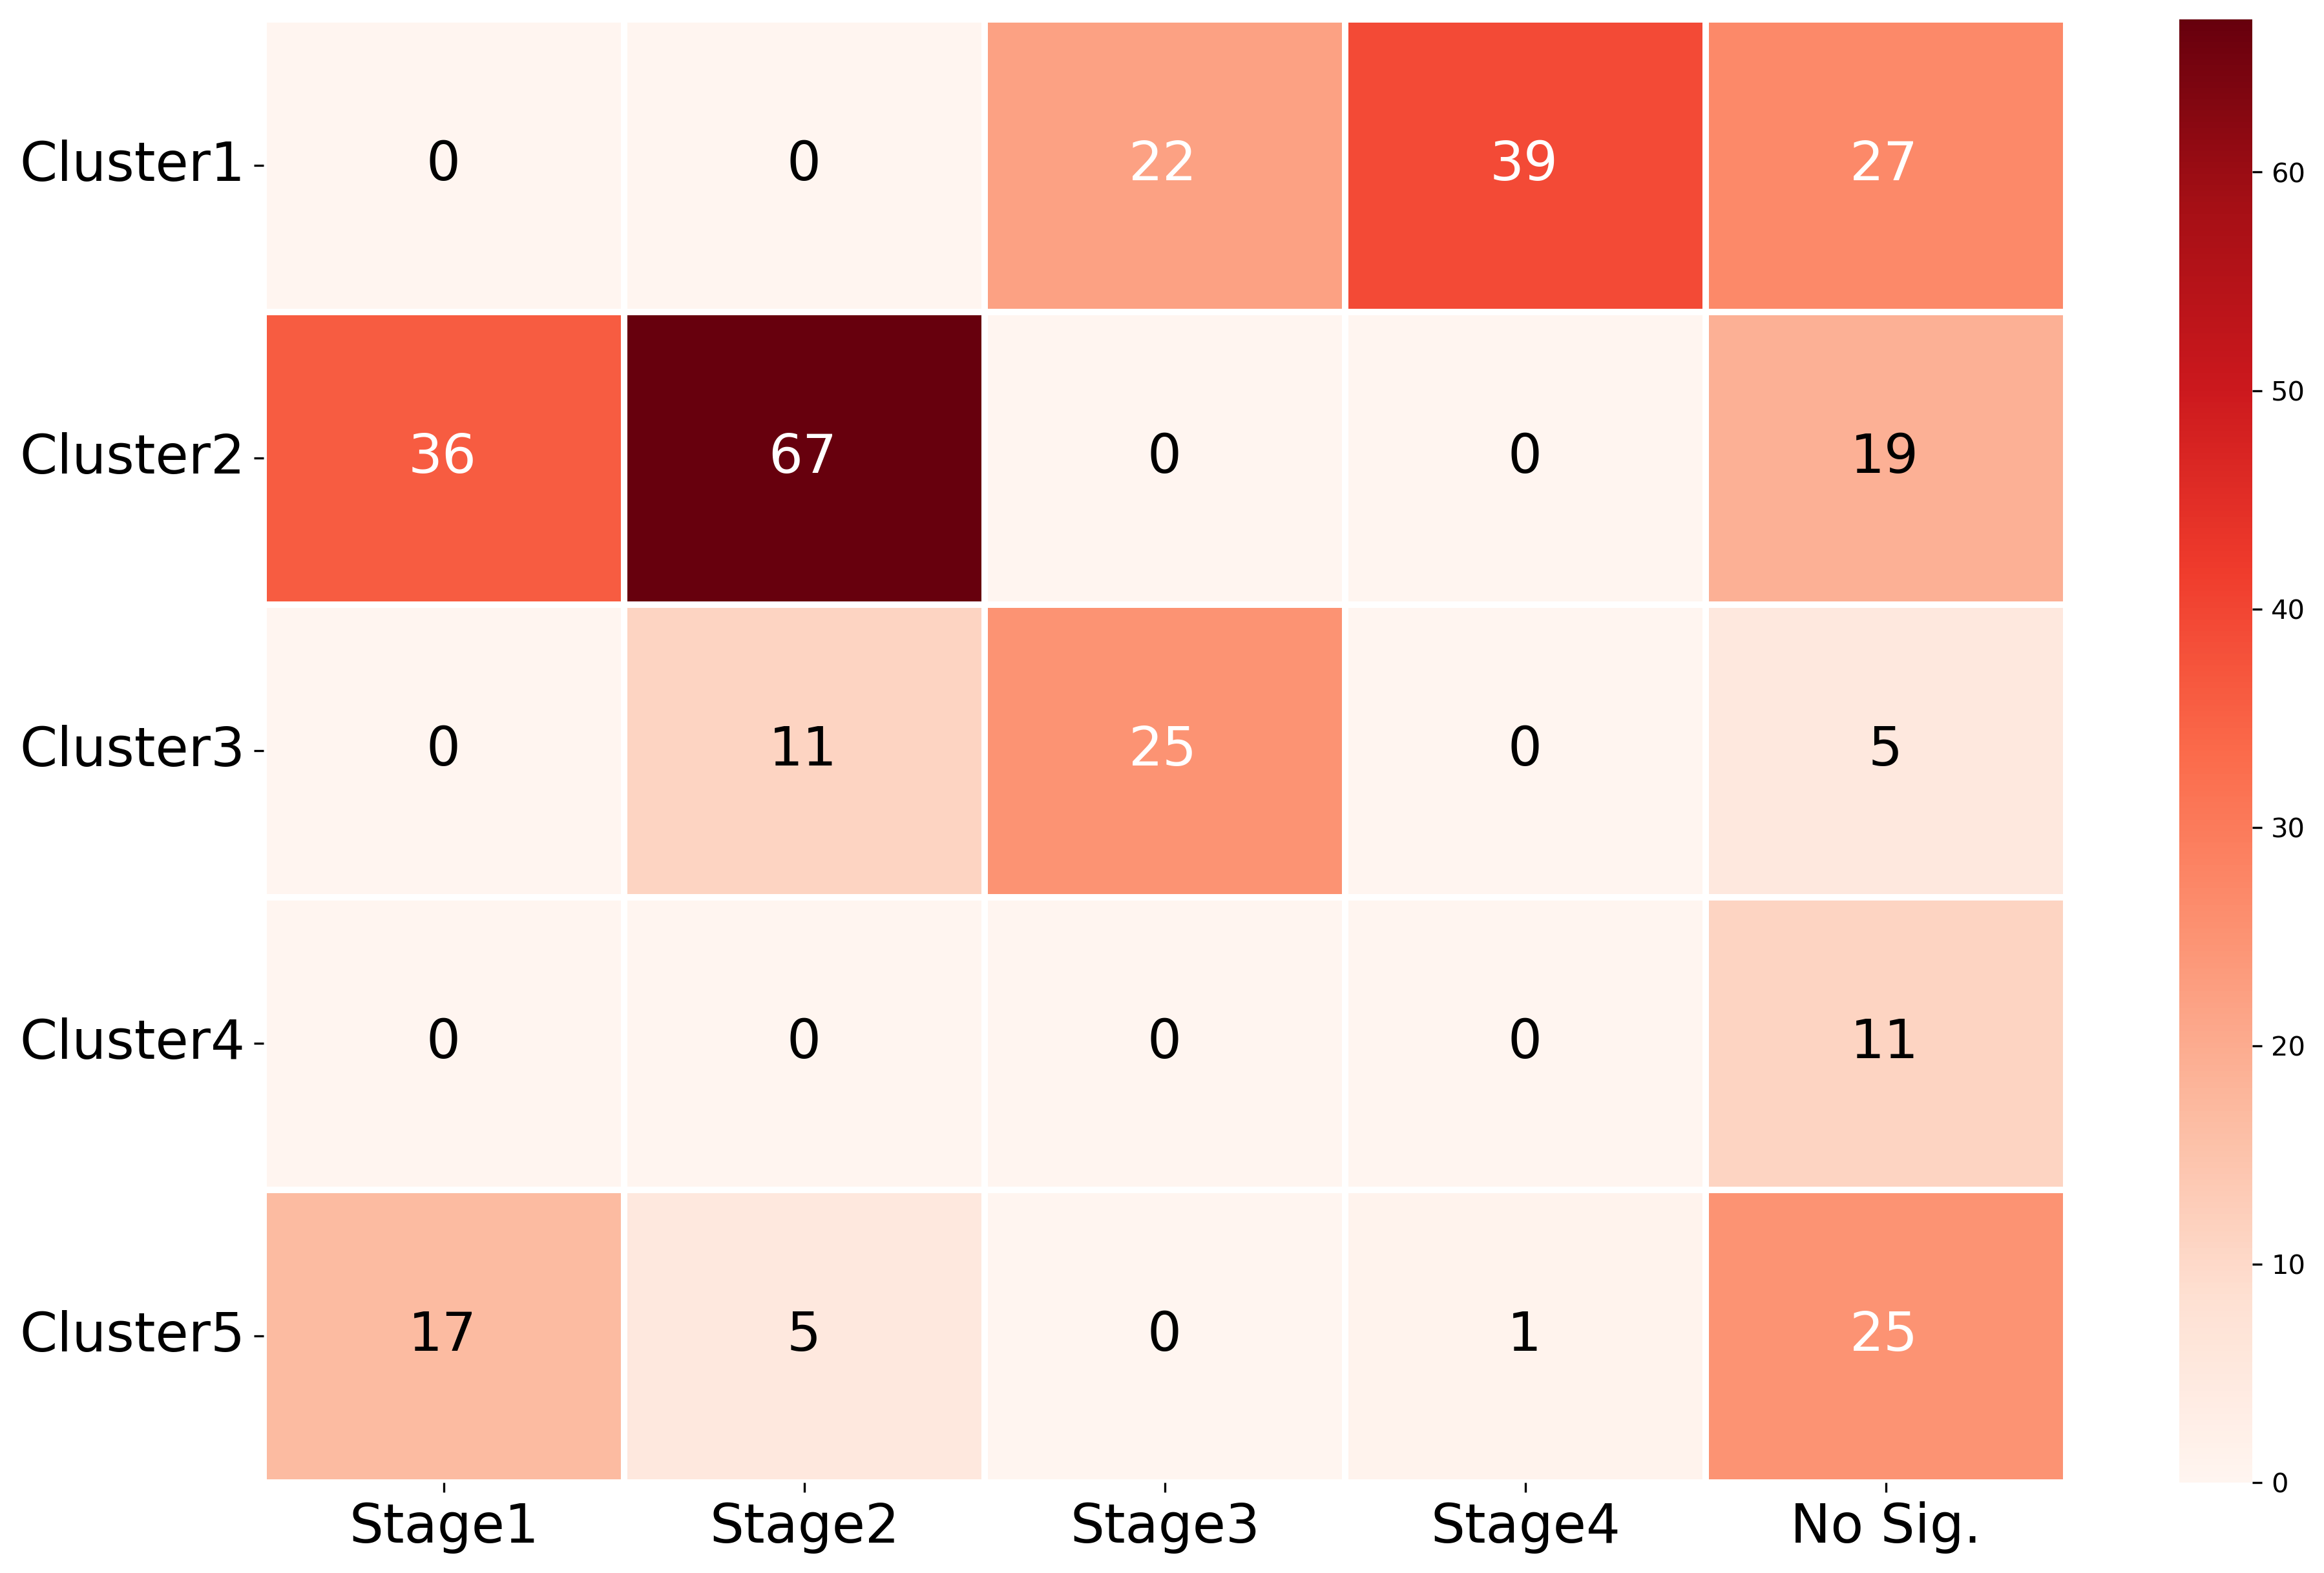

In [156]:
fig = plt.figure(figsize=(15, 10), dpi=300)
ax = plt.subplot(1,1,1)
_ = sns.heatmap(statistc.T, cmap='Reds', vmin=0, vmax=67, linewidths=2)
for i in range(statistc.shape[0]):
    for j in range(statistc.shape[1]):
        value = int(statistc.iloc[i, j])
        _ = ax.annotate(value, (i+(0.45 if value<10 else 0.4), j+0.55), fontsize=20, color='white' if value>20 else 'k')
_ = ax.set_yticklabels(statistc.columns, rotation=0, fontsize=20)
_ = ax.set_xticklabels(statistc.index, fontsize=20)
fig.savefig('../Results_0609/6.1. 不同时期菌种差异数量统计.pdf', dpi=300)

# Example

In [8]:
temp = results.loc[results['taxonomy']=='k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae', :]
temp.shape
set(temp['Cluster'])

(57, 8)

{1, 2, 3, 5}

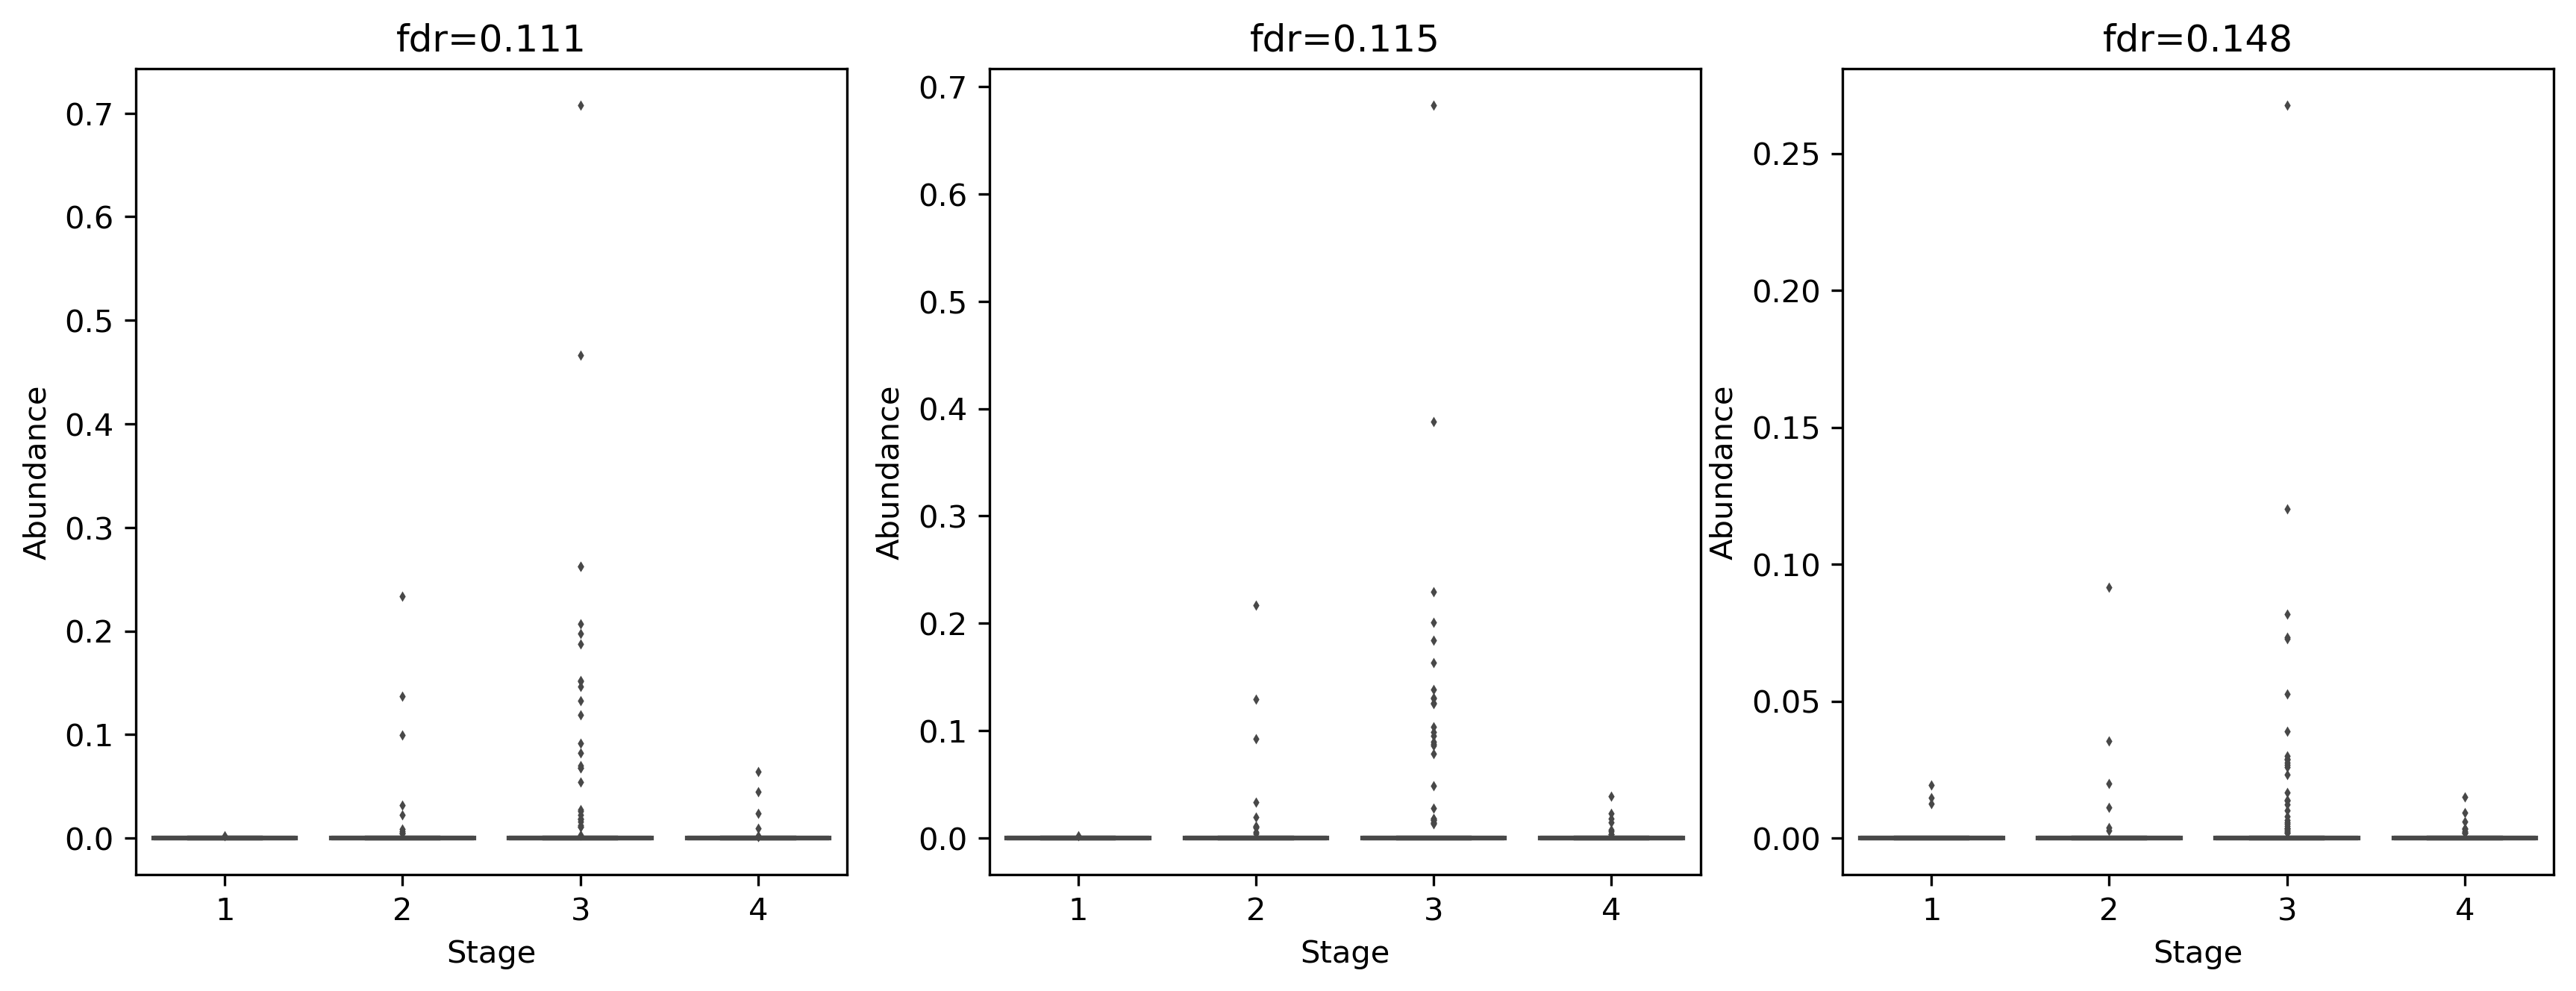

In [13]:
asvs = temp.loc[temp['Cluster']==5, :].index[:3]
pdata = []
for asv in asvs:
    for stage in range(len(stages)):
        for sample in stages[stage]:
            value = data.loc[asv, sample]
            pdata.append([asv, stage+1, sample, np.log10(value+1)])
pdata = pd.DataFrame(pdata, columns=['ASV', 'Stage', 'Sample', 'Abundance'])
#pdata

fig = plt.figure(figsize=(12, 4), dpi=300)
gs = gridspec.GridSpec(1, 3, left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.3)
ax = plt.subplot(gs[0, 0])
_ = sns.boxplot(x='Stage', y='Abundance', data=pdata.loc[pdata['ASV']==asvs[0], :], 
                palette=['#e83929', '#f08300', '#88cb7f', '#a0d8ef'], fliersize=1)
_ = ax.set_title('fdr='+str(round(temp.loc[asvs[0], 'adj.P.Val'], 3)))
ax = plt.subplot(gs[0, 1])
_ = sns.boxplot(x='Stage', y='Abundance', data=pdata.loc[pdata['ASV']==asvs[1], :], 
                palette=['#e83929', '#f08300', '#88cb7f', '#a0d8ef'], fliersize=1)
_ = ax.set_title('fdr='+str(round(temp.loc[asvs[1], 'adj.P.Val'], 3)))
ax = plt.subplot(gs[0, 2])
_ = sns.boxplot(x='Stage', y='Abundance', data=pdata.loc[pdata['ASV']==asvs[2], :], 
                palette=['#e83929', '#f08300', '#88cb7f', '#a0d8ef'], fliersize=1)
_ = ax.set_title('fdr='+str(round(temp.loc[asvs[2], 'adj.P.Val'], 3)))
fig.savefig('../Results_0609/6.1. Enterobacteriaceae_Cluster5_3examples.pdf', dpi=300)